
# 🚜 Predicting the Sale Price of Bulldozers using Machine Learning 

In this notebook, we're going to go through an example machine learning project with the goal of predicting the sale price of bulldozers.

Since we're trying to predict a number, this kind of problem is known as a **regression problem**.

The data and evaluation metric we'll be using (root mean square log error or RMSLE) is from the [Kaggle Bluebook for Bulldozers competition](https://www.kaggle.com/c/bluebook-for-bulldozers/overview).

The techniques used in here have been inspired and adapted from [the fast.ai machine learning course](https://course18.fast.ai/ml).

## 1. Problem Definition
For this dataset, the problem we're trying to solve, or better, the question we're trying to answer is,

>How well can we predict the future sale price of a bulldozer, given its characteristics previous examples of how much similar bulldozers have been sold for?

## 2. Data

Looking at the [dataset from Kaggle](https://www.kaggle.com/c/bluebook-for-bulldozers/data), you can you it's a time series problem. This means there's a time attribute to dataset.

In this case, it's historical sales data of bulldozers. Including things like, model type, size, sale date and more.

There are 3 datasets:
1. **Train.csv** - Historical bulldozer sales examples up to 2011 (close to 400,000 examples with 50+ different attributes, including `SalePrice` which is the **target variable**).
2. **Valid.csv** - Historical bulldozer sales examples from January 1 2012 to April 30 2012 (close to 12,000 examples with the same attributes as **Train.csv**).
3. **Test.csv** - Historical bulldozer sales examples from May 1 2012 to November 2012 (close to 12,000 examples but missing the `SalePrice` attribute, as this is what we'll be trying to predict).

## 3. Evaluation

For this problem, [Kaggle has set the evaluation metric to being root mean squared log error (RMSLE)](https://www.kaggle.com/c/bluebook-for-bulldozers/overview/evaluation). As with many regression evaluations, the goal will be to get this value as low as possible.

To see how well our model is doing, we'll calculate the RMSLE and then compare our results to others on the [Kaggle leaderboard](https://www.kaggle.com/c/bluebook-for-bulldozers/leaderboard).

## 4. Features

Features are different parts of the data. During this step, you'll want to start finding out what you can about the data.

One of the most common ways to do this, is to create a **data dictionary**.

For this dataset, Kaggle provide a data dictionary which contains information about what each attribute of the dataset means. You can [download this file directly from the Kaggle competition page](https://www.kaggle.com/c/bluebook-for-bulldozers/download/Bnl6RAHA0enbg0UfAvGA%2Fversions%2FwBG4f35Q8mAbfkzwCeZn%2Ffiles%2FData%20Dictionary.xlsx) (account required) or view it on Google Sheets.

With all of this being known, let's get started! 

First, we'll import the dataset and start exploring. Since we know the evaluation metric we're trying to minimise, our first goal will be building a baseline model and seeing how it stacks up against the competition.


In [1]:
### Importing the data and preparing it for modelling
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

In [2]:
df = pd.read_csv("../Data/bluebook-for-bulldozers/TrainAndValid.csv", low_memory=False)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   saledate                  412698 non-null  object 
 10  fiModelDesc               412698 non-null  object 
 11  fiBaseModel               412698 non-null  object 
 12  fiSecondaryDesc           271971 non-null  object 
 13  fiModelSeries             58667 non-null   o

In [4]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

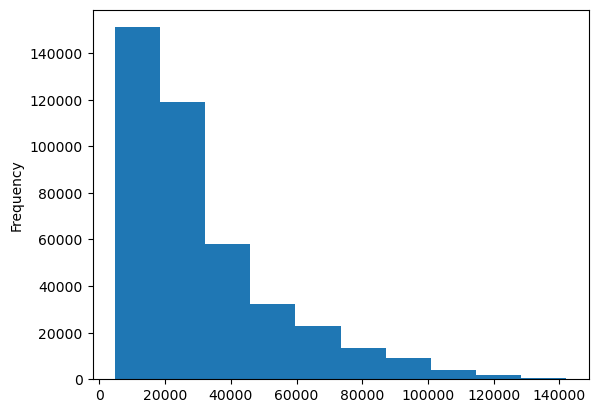

In [5]:
df["SalePrice"].plot.hist();

In [6]:
df = pd.read_csv("../Data/bluebook-for-bulldozers/TrainAndValid.csv", low_memory=False, parse_dates=["saledate"])

df["saledate"].dtype

dtype('<M8[ns]')

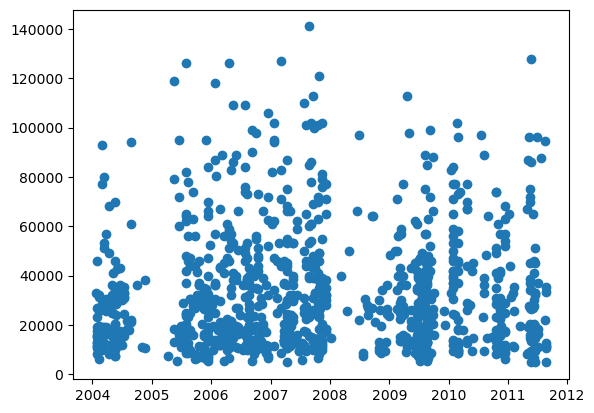

In [7]:
fig, ax = plt.subplots()

ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000])

In [8]:
df.sort_values(by=["saledate"], inplace=True, ascending=True)

df.saledate.head()

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
Name: saledate, dtype: datetime64[ns]

In [9]:
df.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [10]:
df_org = df.copy() 

In [11]:
df["saleYear"] = df.saledate.dt.year
df["saleMonth"] = df.saledate.dt.month
df["saleDay"] = df.saledate.dt.day
df["saleDayofWeek"]= df.saledate.dt.dayofweek
df["saleDayofYear"]= df.saledate.dt.dayofyear

X = df.drop("SalePrice", axis=1)
y = df["SalePrice"]

df.drop("saledate", axis=1, inplace=True)

In [12]:
#Print all string type of the dataset
for label, content in df.items():
    if pd.api.types.is_string_dtype(content):
        print(label)

UsageBand
fiModelDesc
fiBaseModel
fiSecondaryDesc
fiModelSeries
fiModelDescriptor
ProductSize
fiProductClassDesc
state
ProductGroup
ProductGroupDesc
Drive_System
Enclosure
Forks
Pad_Type
Ride_Control
Stick
Transmission
Turbocharged
Blade_Extension
Blade_Width
Enclosure_Type
Engine_Horsepower
Hydraulics
Pushblock
Ripper
Scarifier
Tip_Control
Tire_Size
Coupler
Coupler_System
Grouser_Tracks
Hydraulics_Flow
Track_Type
Undercarriage_Pad_Width
Stick_Length
Thumb
Pattern_Changer
Grouser_Type
Backhoe_Mounting
Blade_Type
Travel_Controls
Differential_Type
Steering_Controls


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 57 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 73670 non-null   object 
 9   fiModelDesc               412698 non-null  object 
 10  fiBaseModel               412698 non-null  object 
 11  fiSecondaryDesc           271971 non-null  object 
 12  fiModelSeries             58667 non-null   object 
 13  fiModelDescriptor         74816 non-nul

In [14]:
#Convert all string into panda categories
for label, content in df.items():
    if(pd.api.types.is_string_dtype(content)):
        df[label]= content.astype("category").cat.as_ordered()
    

In [15]:
#Add missing numeric values with the median
for label, content in df.items():
    if(pd.api.types.is_numeric_dtype(content)):
        if(pd.isnull(content).sum()):
            # Add a binary column which tells if the data was missing our not
            df[label+"_was_missing"]= pd.isnull(content)
            # Fill missing numeric values with median since it's more robust than the mean
            df[label]= content.fillna(content.median())

In [16]:
# Turn categorical variables into numbers
for label, content in df.items():
    if not (pd.api.types.is_numeric_dtype(content)):
        df[label+"_was_missing"]= pd.isnull(content)
        df[label]= pd.Categorical(content).codes + 1 

## Modeling

In [17]:
from sklearn.ensemble import RandomForestRegressor


X = df.drop("SalePrice", axis=1)
y = df["SalePrice"]

In [18]:
df_train = df [df["saleYear"]!=2012]
df_val = df [df["saleYear"]== 2012]

len(df_val), len(df_train)

(11573, 401125)

In [19]:
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train["SalePrice"]
X_val , y_val = df_val.drop("SalePrice", axis=1), df_val["SalePrice"]

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((401125, 102), (401125,), (11573, 102), (11573,))

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_log_error 

def show_score(model):
    train_pred = model.predict(X_train)
    val_pred = model.predict(X_val) 
    scores= {"MAE_train": mean_absolute_error(y_train, train_pred),
             "MAE_Val": mean_absolute_error(y_val, val_pred),
             "RMSLE_train": mean_squared_log_error(y_train, train_pred, squared=False),
             "RMSLE_val": mean_squared_log_error(y_val, val_pred, squared=False),
             "Training R^2": model.score(X_train, y_train),
             "Validation R^2": model.score(X_val, y_val)}
    return scores

In [21]:
model= RandomForestRegressor(n_jobs=-1, max_samples=10000, random_state=42)

In [22]:
%%time
model.fit(X_train, y_train)

Wall time: 4.74 s


RandomForestRegressor(max_samples=10000, n_jobs=-1, random_state=42)

In [23]:
show_score(model)

{'MAE_train': 5561.2988092240585,
 'MAE_Val': 7177.26365505919,
 'RMSLE_train': 0.257745378256977,
 'RMSLE_val': 0.29362638671089003,
 'Training R^2': 0.8606658995199189,
 'Validation R^2': 0.8320374995090507}

### Hypertuning: RandomizeSearchCV

In [24]:
%%time 
from sklearn.model_selection import RandomizedSearchCV

rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20,2), 
           "min_samples_leaf": np.arange(1, 20,2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples" : [10000]}

RandomCV_model= RandomizedSearchCV(RandomForestRegressor(), param_distributions=rf_grid, 
                                  n_iter=2, cv=5, verbose=True, random_state=42)

RandomCV_model.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Wall time: 42.1 s


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=2,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   random_state=42, verbose=True)

In [25]:
RandomCV_model.best_params_

{'n_estimators': 60,
 'min_samples_split': 12,
 'min_samples_leaf': 1,
 'max_samples': 10000,
 'max_features': 1,
 'max_depth': None}

In [26]:
show_score(RandomCV_model)

{'MAE_train': 8839.335267865048,
 'MAE_Val': 11222.024413995565,
 'RMSLE_train': 0.389799500198771,
 'RMSLE_val': 0.4441925690554826,
 'Training R^2': 0.6859452324187911,
 'Validation R^2': 0.6415598428594234}

### Train a model with the best parameters

I tried 100 different combinations of hyperparameters (setting `n_iter` to 100 in `RandomizedSearchCV`) and found the best results came from the ones you see below.

In [27]:
ideal_model = RandomForestRegressor(n_estimators=40,  
                                   min_samples_leaf=3, 
                                   max_features=0.5, 
                                   n_jobs=-1)
ideal_model.fit(X_train, y_train)

RandomForestRegressor(max_features=0.5, min_samples_leaf=3, n_estimators=40,
                      n_jobs=-1)

In [28]:
show_score(ideal_model)

{'MAE_train': 2543.838545169054,
 'MAE_Val': 5929.5456771714435,
 'RMSLE_train': 0.12944150765045234,
 'RMSLE_val': 0.243956619624813,
 'Training R^2': 0.967170675817895,
 'Validation R^2': 0.8811627502901345}

## Make Predictions on Test Data

In [29]:
df_test = pd.read_csv("../Data/bluebook-for-bulldozers/Test.csv", low_memory=False, parse_dates=["saledate"])

In [30]:
#Preprocessing Dataset 
def preprocessing_data(df):
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayofWeek"]= df.saledate.dt.dayofweek
    df["saleDayofYear"]= df.saledate.dt.dayofyear

    # Drop original saledate
    df.drop("saledate", axis=1, inplace=True)

    # Fill numeric rows with the median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                df[label+"_was_missing"] = pd.isnull(content)
                df[label] = content.fillna(content.median())
                
        # Turn categorical variables into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_was_missing"] = pd.isnull(content)
            # We add the +1 because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes+1
    return df



In [31]:
df_test = preprocessing_data(df_test)

In [41]:
df_test["auctioneerID_was_missing"] = False
df_test = df_test.reindex(columns=list(X_train.columns))

In [42]:
test_preds = ideal_model.predict(df_test)

In [43]:
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalePrice"] = test_preds
df_preds

,SalesID,SalePrice
0,1227829,18559.818948
1,1227844,18394.947781
2,1227847,50912.106782
3,1227848,70080.148810
4,1227863,55892.336310
...,...,...
12452,6643171,41548.634248
12453,6643173,14500.768849
12454,6643184,14649.782873
12455,6643186,18696.498016


In [171]:
#Export to CSV
df_preds.to_csv("../Blue Book for Bulldozers/Kaggle_formatted_predictions.csv")

In [169]:
# Find feature importance of our best model
ideal_model.feature_importances_

array([3.54058850e-02, 2.12904724e-02, 4.45458962e-02, 1.82882012e-03,
       3.84290016e-03, 1.98543255e-01, 3.14600716e-03, 1.09967484e-03,
       4.41751691e-02, 3.69263003e-02, 6.40370940e-02, 4.60067423e-03,
       1.46350034e-02, 1.42723191e-01, 4.47618223e-02, 7.17072928e-03,
       3.05699023e-03, 1.84037297e-03, 2.58331635e-03, 7.07982257e-02,
       3.62858858e-04, 4.22486507e-05, 1.53731189e-03, 2.04856035e-04,
       1.08909957e-03, 1.94188977e-05, 7.36442664e-05, 2.64158795e-03,
       5.99465297e-03, 1.53884004e-04, 2.15413366e-03, 3.82412610e-03,
       4.29752591e-03, 5.80843538e-04, 2.17266798e-03, 7.57121349e-03,
       9.80503907e-04, 1.09920327e-02, 2.48984257e-03, 3.13292568e-03,
       1.29736614e-03, 8.76663719e-04, 6.22120153e-03, 6.34204020e-04,
       5.73804180e-04, 3.35510554e-04, 8.95899710e-04, 2.42598989e-03,
       9.50169069e-04, 1.83778405e-04, 5.02566284e-04, 7.43198893e-02,
       4.96743924e-03, 7.25460175e-03, 3.69281677e-03, 1.12789817e-02,
      

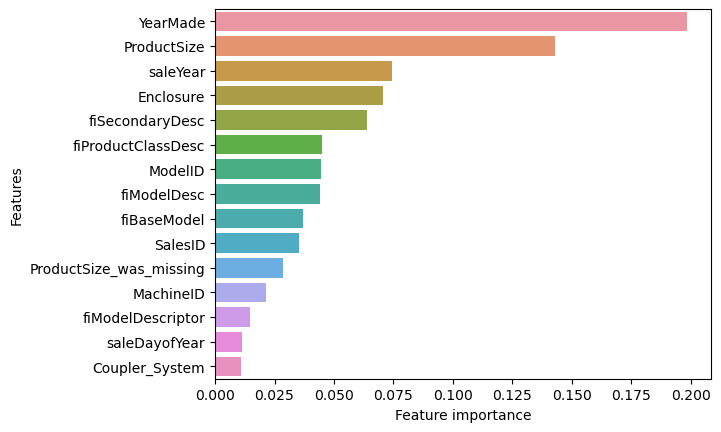

In [223]:
import seaborn as sns
import matplotlib.pyplot as plt

def plot_features(columns, importances):
    df = (pd.DataFrame({"features": columns,
                        "feature_importance": importances})
          .sort_values("feature_importance", ascending=False)
          .reset_index(drop=True))
    
    # Plot the dataframe
    sns.barplot(x="feature_importance",
                y="features",
                data=df[:15],
                orient="h")
    plt.xlabel("Feature importance")
    plt.ylabel("Features")    

    
plot_features(X_train.columns, ideal_model.feature_importances_)